# Calibrate Cremat Preamp + Shaper

See ./picoScopeControl for implementation of functions. picosdk required. run

 `python -m pip install . `

_after_ installing the picosdk on the system

## Open Device (only do once)

In [195]:
from picosdk.ps3000a import ps3000a as ps
print("Closing Unit")
# Closes the unit
status = ps.ps3000aCloseUnit(chandle)
assert_pico_ok(status)

print("Closed")

Closing Unit
Closed


In [120]:
from picoScopeControl import *
from pprint import pprint
chandle = openDevice()
pprint(rangeMap)

Opening unit
Sucess
{0.01: 0,
 0.02: 1,
 0.05: 2,
 0.1: 3,
 0.2: 4,
 0.5: 5,
 1: 6,
 2: 7,
 5: 8,
 10: 9,
 20: 10,
 50: 11}


### Configure metadata
Set accordingly. Will be put in plot as annotation and in file name

In [10]:
metadata = {
    "switchconfig" : "10",
    "stacknum" : 2
}

## Test Measurement and Fit

Setting square wave f=90 hz, A=0.1 V
Sampling Data. Channel=2, trigger=70.0mV, window=5e-06, range=1
Done

Setting square wave f=90 hz, A=0.156 V
Sampling Data. Channel=2, trigger=109.0mV, window=5e-06, range=1
Done

Setting square wave f=90 hz, A=0.212 V
Sampling Data. Channel=2, trigger=148.0mV, window=5e-06, range=1
Done

Setting square wave f=90 hz, A=0.091 V
Sampling Data. Channel=3, trigger=0mV, window=5e-06, range=9
Done



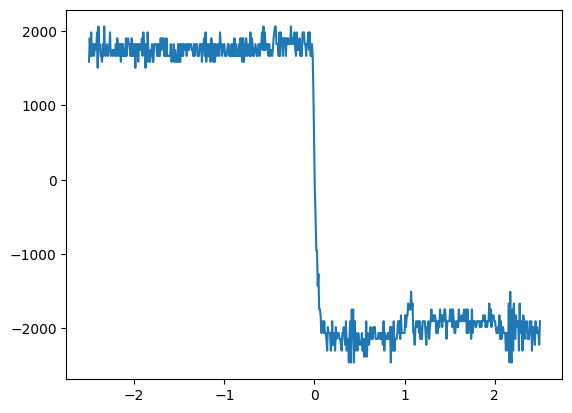

In [194]:
t, data = takeDataVal(chandle, .091, rangeMap[10] , trigger=0, window=5e-6, channel=3) # Send a test pulse of amplitude 0.5V, get data, and show plot.
#pps, errs = fitGaussian(t, data) # Fit to gauss
plt.plot(t, data)
#plt.plot(t, gauss(t, *pps))
plt.show()

## Run Measurements

In [115]:

#input_vs = np.round(np.linspace(.1, 2, 35), 3) #input voltages to sweep
input_vs = np.round(np.linspace(.2, .35, 10), 3)
#trigger_mv = 200 #trigger
trigger_mvs = np.round(input_vs*1e3 * 0) #list of triggers, NOTE must be in mv
#allows for variable trigger; setting equal to input is good if gain > 1

window = 5e-6 #seconds, width of capture


initRange = 4 #inial voltage range for device
t, datas = getSamples(chandle,input_vs, initRange, trigger_mvs, window) # sweep input voltages and take all data points
#plotSample(t, data)
gains, gains_err = getGains(t, datas)

Setting square wave f=90 hz, A=0.2 V
Sampling Data. Channel=2, trigger=0.0mV, window=5e-06, range=4
Done

Setting square wave f=90 hz, A=0.217 V
Sampling Data. Channel=2, trigger=0.0mV, window=5e-06, range=4
Done

Maxed out range
Signal out of range, increasing max range to +- 0.5 V

Setting square wave f=90 hz, A=0.217 V
Sampling Data. Channel=2, trigger=0.0mV, window=5e-06, range=5
Done

Maxed out range
Signal out of range, increasing max range to +- 1 V

Setting square wave f=90 hz, A=0.217 V
Sampling Data. Channel=2, trigger=0.0mV, window=5e-06, range=6
Done

Setting square wave f=90 hz, A=0.233 V
Sampling Data. Channel=2, trigger=0.0mV, window=5e-06, range=6
Done

Maxed out range
Signal out of range, increasing max range to +- 2 V

Setting square wave f=90 hz, A=0.233 V
Sampling Data. Channel=2, trigger=0.0mV, window=5e-06, range=7
Done

Maxed out range
Signal out of range, increasing max range to +- 5 V

Setting square wave f=90 hz, A=0.233 V
Sampling Data. Channel=2, trigger=0.0

10it [00:00, 131.99it/s]


## Create Plot

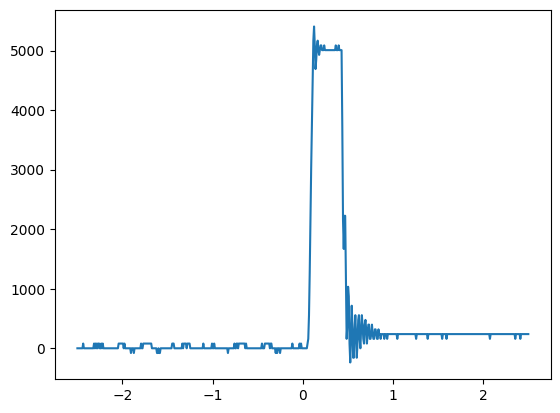

In [18]:
plt.plot(t[-1],datas[-1])

In [117]:
input_vs = input_vs[2:]
gains = gains[2:]

Gain w/ error: 16.7+/-1.7


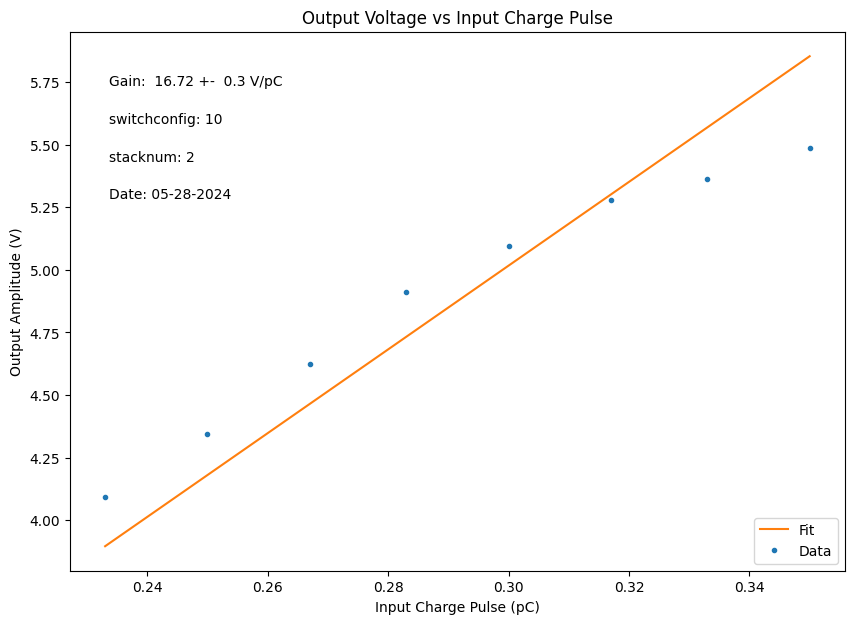

In [118]:
from uncertainties import ufloat
## DATE
from datetime import datetime
now = datetime.now() # current date and time
datestr = now.strftime("%m-%d-%Y")

## Convert units
input_charges = input_vs * 1 #times 1 pF, convert to pF
output_V = np.asarray(gains) * 1e-3 #mV to V
output_err = np.asarray(gains_err) * 1e-3

## Fit linear function
linear = lambda x, m: m*x
pps, cov = curve_fit(linear, input_charges, output_V)
perr = np.sqrt(np.diag(cov))


#DEAL WITH UNITS AND ERROR
gain = ufloat(pps[0], perr[0]) #V/V
capacitance = ufloat(1, .1) #pF, += 10%
print("Gain w/ error:", gain/capacitance)



## Plot
plt.figure(figsize=(10, 7))

plt.errorbar(input_charges, output_V,capsize=3, fmt=".",
             label="Data")
plt.plot(input_charges, linear(input_charges, *pps), label="Fit")

plt.title("Output Voltage vs Input Charge Pulse")
plt.xlabel("Input Charge Pulse (pC)")
plt.ylabel("Output Amplitude (V)")
plt.legend(loc="lower right")


## annotations
x = .05
y = .9
y_spacing = 0.07

# Gain label
plt.annotate(f"Gain: {pps[0] : .4g} +- {perr[0] : .1g} V/pC", (x, y), xycoords="axes fraction")


# Label all metadata fields
for item in metadata.keys():
    y -= y_spacing #shift text down
    plt.annotate(f"{item}: {metadata[item]}", (x, y) , xycoords="axes fraction") 

# label date of calibration
y -= y_spacing
plt.annotate(f"Date: {datestr}", (x, y) , xycoords="axes fraction")

## give file unique name, save to png and svg
out_name = f"out-{datestr}"
for key in metadata.keys():
    out_name += f"-{metadata[key]}"
    
plt.savefig(f"./out/{out_name}.svg") # svg

plt.savefig(f"./out/{out_name}.png") # png


plt.show()

## Close Unit (do once at the end)

In [192]:
from picosdk.ps3000a import ps3000a as ps
print("Closing Unit")
# Closes the unit
status = ps.ps3000aCloseUnit(chandle)
assert_pico_ok(status)

print("Closed")

Closing Unit
Closed


In [ ]:
pass